In [2]:
# Importing the necessary libraries
import lyricsgenius as genius
import pandas as pd
import string 
import numpy as np
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
import nltk.data
import time   
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('punkt')
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import re
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dogan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dogan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Reloading the data
df_all = pd.read_csv('df_all_e.csv', sep='%')
df_upd = pd.read_csv('df_upd_e.csv', sep='%')
df_all = df_all.drop('Unnamed: 0', 1)
df_upd = df_upd.drop('Unnamed: 0', 1)

In [4]:
# Setting the labels as the Energy sentiment labels
df = pd.DataFrame()
df['Lyrics'] = df_upd['Lyrics']
df['Label'] = df_upd['Energy Label']
df

,Lyrics,Label
0,"load up on guns, bring your friends it's fun...",up
1,there's a lady who's sure all that glitte...,down
2,is this the real life? is this just fantasy?...,down
3,imagine there's no heaven it's easy if you t...,down
4,i can't get no satisfaction i can't get n...,up
...,...,...
5316,once you're in the zone the river flows down...,up
5317,everybody's lazy when they're tired 'cause e...,up
5318,"do do do do, do do do do do do do do do do d...",up
5319,"water, hot water hot water, hot water hot wa...",up


In [5]:
# Removing '—' from lyrics, otherwise it comes up as the most frequent word after lemmatization
# Will be replaced with '' so that it will semantically be equivalent to a new word
# E.g: self-assured -> selfassured
for index, row in df.iterrows():
    if ('-' in row['Lyrics'])or('—' in row['Lyrics']):
        row['Lyrics'] = row['Lyrics'].replace('-', ' ')
        row['Lyrics'] = row['Lyrics'].replace('—', ' ')
df

,Lyrics,Label
0,"load up on guns, bring your friends it's fun...",up
1,there's a lady who's sure all that glitte...,down
2,is this the real life? is this just fantasy?...,down
3,imagine there's no heaven it's easy if you t...,down
4,i can't get no satisfaction i can't get n...,up
...,...,...
5316,once you're in the zone the river flows down...,up
5317,everybody's lazy when they're tired 'cause e...,up
5318,"do do do do, do do do do do do do do do do d...",up
5319,"water, hot water hot water, hot water hot wa...",up


In [6]:
#Functions for tokenization
#Also does lemmatization to each word
def lyrics_to_words(document):

    stop_words = set(stopwords.words('english'))
    #For dealing with the negations
    stop_words.remove('not')
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

def unique(list1): 
     # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    
    return unique_list

In [7]:
cleaned_lyrics=[]
for lyric in df['Lyrics'].tolist():
    cleaned_lyrics.append(lyrics_to_words(lyric))
    
df['Lemmatized Lyrics']=cleaned_lyrics
df

,Lyrics,Label,Lemmatized Lyrics
0,"load up on guns, bring your friends it's fun...",up,load gun bring friend fun lose pretend bored s...
1,there's a lady who's sure all that glitte...,down,there lady who sure glitter gold buying stairw...
2,is this the real life? is this just fantasy?...,down,real life fantasy caught landslide escape real...
3,imagine there's no heaven it's easy if you t...,down,imagine there heaven easy try hell u u sky ima...
4,i can't get no satisfaction i can't get n...,up,cant get satisfaction cant get satisfaction ca...
...,...,...,...
5316,once you're in the zone the river flows down...,up,zone river flow like full stone water bed ripp...
5317,everybody's lazy when they're tired 'cause e...,up,everybodys lazy theyre tired cause everybodys ...
5318,"do do do do, do do do do do do do do do do d...",up,do do do do watch movie 3d strange cellophane ...
5319,"water, hot water hot water, hot water hot wa...",up,water hot water hot water hot water hot water ...


In [9]:
# Replacing "not " with "_"
# This is a semi-manuel attempt to detect negations, such that statements like "not good" will be represented by "_good"
# This will allow the vocabulary to give different indexes to words whenever they follow the word "not"

for index, row in df.iterrows():
    if ('not ' in row['Lemmatized Lyrics']):
        row['Lemmatized Lyrics'] = row['Lemmatized Lyrics'].replace('not ', '_')
df

,Lyrics,Label,Lemmatized Lyrics
0,"load up on guns, bring your friends it's fun...",up,load gun bring friend fun lose pretend bored s...
1,there's a lady who's sure all that glitte...,down,there lady who sure glitter gold buying stairw...
2,is this the real life? is this just fantasy?...,down,real life fantasy caught landslide escape real...
3,imagine there's no heaven it's easy if you t...,down,imagine there heaven easy try hell u u sky ima...
4,i can't get no satisfaction i can't get n...,up,cant get satisfaction cant get satisfaction ca...
...,...,...,...
5316,once you're in the zone the river flows down...,up,zone river flow like full stone water bed ripp...
5317,everybody's lazy when they're tired 'cause e...,up,everybodys lazy theyre tired cause everybodys ...
5318,"do do do do, do do do do do do do do do do d...",up,do do do do watch movie 3d strange cellophane ...
5319,"water, hot water hot water, hot water hot wa...",up,water hot water hot water hot water hot water ...


In [10]:
# Creating a dictionary containing the frequency of words used
from collections import Counter
lyrics_list = df['Lemmatized Lyrics'].tolist()
all_text2 = ' '.join(lyrics_list)
words = all_text2.split()
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)
print (count_words)

Counter({'im': 14850, 'one': 14209, 'like': 13680, 'know': 12947, 'say': 12034, 'love': 10905, 'go': 10579, 'time': 10276, 'oh': 9863, 'get': 9311, 'would': 8941, 'come': 8910, 'day': 8338, 'see': 8333, 'got': 7727, 'said': 7632, 'me': 7397, 'never': 7298, 'yeah': 7017, 'want': 6929, 'take': 6929, 'thing': 6771, 'man': 6736, 'make': 6659, 'back': 6606, 'way': 6552, 'well': 6501, 'you': 6473, 'it': 6461, 'u': 6401, 'could': 6121, 'let': 5917, 'tell': 5771, 'life': 5599, 'little': 5490, 'away': 5217, 'cant': 5093, 'good': 5092, 'eye': 5062, 'right': 5062, 'night': 5061, 'there': 4921, 'baby': 4832, 'ill': 4596, 'look': 4462, 'feel': 4313, 'hand': 4286, 'give': 4267, 'world': 4177, 'him': 4116, 'think': 4036, 'people': 3880, 'de': 3830, 'every': 3812, 'made': 3781, 'home': 3750, 'thats': 3700, 'going': 3681, 'long': 3663, 'two': 3641, 'head': 3639, 'gonna': 3568, 'girl': 3553, 'still': 3542, 'he': 3537, 'need': 3512, 'cause': 3507, 'woman': 3506, 'boy': 3498, 'heart': 3468, 'old': 3442, '

In [11]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
print (vocab_to_int)

{'im': 1, 'one': 2, 'like': 3, 'know': 4, 'say': 5, 'love': 6, 'go': 7, 'time': 8, 'oh': 9, 'get': 10, 'would': 11, 'come': 12, 'day': 13, 'see': 14, 'got': 15, 'said': 16, 'me': 17, 'never': 18, 'yeah': 19, 'want': 20, 'take': 21, 'thing': 22, 'man': 23, 'make': 24, 'back': 25, 'way': 26, 'well': 27, 'you': 28, 'it': 29, 'u': 30, 'could': 31, 'let': 32, 'tell': 33, 'life': 34, 'little': 35, 'away': 36, 'cant': 37, 'good': 38, 'eye': 39, 'right': 40, 'night': 41, 'there': 42, 'baby': 43, 'ill': 44, 'look': 45, 'feel': 46, 'hand': 47, 'give': 48, 'world': 49, 'him': 50, 'think': 51, 'people': 52, 'de': 53, 'every': 54, 'made': 55, 'home': 56, 'thats': 57, 'going': 58, 'long': 59, 'two': 60, 'head': 61, 'gonna': 62, 'girl': 63, 'still': 64, 'he': 65, 'need': 66, 'cause': 67, 'woman': 68, 'boy': 69, 'heart': 70, 'old': 71, 'year': 72, 'face': 73, 'mind': 74, 'first': 75, 'nothing': 76, 'la': 77, 'must': 78, 'another': 79, 'around': 80, 'even': 81, 'now': 82, 'ive': 83, 'might': 84, 'god':

In [12]:
#Tokenization
lyrics_split = df['Lemmatized Lyrics'].tolist()

lyrics_int = []
for lyric in lyrics_split:
    l = [vocab_to_int[w] for w in lyric.split()]
    lyrics_int.append(l)
print (lyrics_int[0:3])

[[2183, 497, 280, 92, 671, 519, 1467, 3057, 683, 2255, 9, 95, 4, 805, 100, 954, 954, 954, 612, 954, 954, 954, 612, 954, 954, 954, 612, 954, 954, 954, 96, 212, 193, 2627, 82, 4561, 30, 46, 1517, 11597, 82, 4561, 30, 18749, 32664, 12644, 27579, 19, 106, 10404, 1, 1066, 235, 1518, 46, 2063, 35, 1561, 90, 90, 120, 954, 954, 954, 612, 954, 954, 954, 612, 954, 954, 954, 612, 954, 954, 954, 96, 212, 193, 2627, 82, 4561, 30, 46, 1517, 11597, 82, 4561, 30, 18749, 32664, 12644, 27579, 19, 106, 10404, 538, 824, 9, 19, 716, 24, 264, 176, 210, 210, 87, 9, 27, 608, 13896, 954, 954, 954, 612, 954, 954, 954, 612, 954, 954, 954, 612, 954, 954, 954, 96, 212, 193, 2627, 82, 4561, 30, 46, 1517, 11597, 82, 4561, 30, 18749, 32664, 12644, 27579, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082], [42, 282, 309, 234, 5806, 581, 3618, 12645, 356, 10, 4, 1474, 1562, 100, 10, 139, 136, 136, 3618, 12645, 356, 42, 561, 258, 20, 234, 67, 4, 393, 100, 60, 1267, 582, 6074, 42, 17418, 2363, 393, 117, 54987, 136, 24

In [13]:
# Categorization of labels
labels_split = df['Label'].tolist()
encoded_labels = [1 if label =='up' else 0 for label in labels_split]
encoded_labels = np.array(encoded_labels)

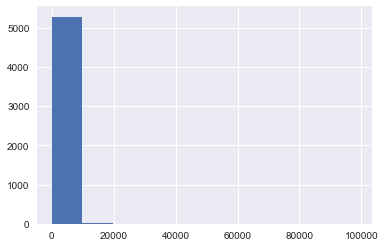

count     5321.000000
mean       443.877843
std       3315.951675
min          7.000000
25%         93.000000
50%        123.000000
75%        162.000000
max      98350.000000
dtype: float64

In [14]:
# Lyrics Length
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
lyrics_len = [len(x) for x in lyrics_int]
pd.Series(lyrics_len).hist()
plt.show()
pd.Series(lyrics_len).describe()

In [15]:
# Padding/Truncating
def pad_features(lyrics_int, seq_length):
    features = np.zeros((len(lyrics_int), seq_length), dtype = int)
    
    for i, lyric in enumerate(lyrics_int):
        lyric_len = len(lyric)
        
        if lyric_len <= seq_length:
            zeroes = list(np.zeros(seq_length-lyric_len))
            new = zeroes+lyric
        elif lyric_len > seq_length:
            new = lyric[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [16]:
# Lyrics as array
features = pad_features(lyrics_int, 200)
features

array([[    0,     0,     0, ...,  4082,  4082,  4082],
       [    0,     0,     0, ...,  3618, 12645,   356],
       [    0,     0,     0, ...,    26,   514,   780],
       ...,
       [    0,     0,     0, ...,   227,   227,   227],
       [    0,     0,     0, ...,   209,   473,   209],
       [    0,     0,     0, ...,  1359, 10765,  1147]])

In [17]:
# Training, Validation and Test Dataset Split
split_frac = 0.8
train_x = features[0:int(split_frac*len(features))]
train_y = encoded_labels[0:int(split_frac*len(features))]


remaining_x = features[int(split_frac*len(features)):]
remaining_y = encoded_labels[int(split_frac*len(features)):]


valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


In [18]:
#Dataloaders and Batching
import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [19]:
# Setting the device to gpu for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# Model
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim,batch_first=True,bidirectional=True, 
                           dropout=0.5)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        packed_output, (hidden, cell) = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        hidden = self.dropout(hidden[-1,:,:])
        
        
        x = self.fc(hidden.squeeze(0))
        
        return x

In [21]:
# Setting the parameters for the model
INPUT_DIM = len(vocab_to_int)+1
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1


model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

C:\Users\Dogan\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [22]:
# To see number of parameters the model has
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
model

The model has 10,352,041 trainable parameters


RNN(
  (embedding): Embedding(96186, 100)
  (rnn): LSTM(100, 256, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:
# Getting the optimizer&criterion from torch
# Moving them to gpu 
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [24]:
# Binary accuracy function, will be shown during training
# Accuracy is not a good indicator for classification tasks, recall and precision will be observed later
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics(preds, y):
    

    preds_ = preds.cpu().detach().numpy()
    y_ = y.cpu().detach().numpy()
    
    rounded_preds = np.where(preds_ > 0.5, 1, 0)
    
    precision = precision_score(rounded_preds, y_)
    recall = recall_score(rounded_preds, y_)
    f1 = f1_score(rounded_preds, y_)
    
    return precision, recall, f1

In [26]:
# Training function
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    epoch_prec = 0
    epoch_rec = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch_x, batch_y in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch_x.to(device)).squeeze(1)

        batch_y = batch_y.float()
        
        loss = criterion(predictions, batch_y.to(device))
        
        acc = binary_accuracy(predictions, batch_y.to(device))
        
        precision, recall, f1 = metrics(predictions, batch_y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        epoch_prec += precision.item()
        epoch_rec += recall.item()
        epoch_f1 += f1.item()
        
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator), epoch_f1 / len(iterator) 

In [27]:
# Evaluation function for validation and testing
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    epoch_prec = 0
    epoch_rec = 0
    epoch_f1 = 0
    
    
    model.eval()
    
    with torch.no_grad():
    
        for batch_x, batch_y in iterator:

            predictions = model(batch_x.to(device)).squeeze(1)
            batch_y = batch_y.float()
            loss = criterion(predictions, batch_y.to(device))
            
            acc = binary_accuracy(predictions, batch_y.to(device))
            
            precision, recall, f1 = metrics(predictions, batch_y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            epoch_prec += precision.item()
            epoch_rec += recall.item()
            epoch_f1 += f1.item()
        
    return  epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator), epoch_f1 / len(iterator) 

In [28]:
# Helper function to observe epoch times
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
#Training
N_EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_prec, valid_rec, valid_f1 = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Prec: {train_prec*100:.2f}% | Train Rec: {train_rec*100:.2f}% | Train F1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Valid Prec: {valid_prec*100:.2f}% | Valid Rec: {valid_rec*100:.2f}% | Valid F1: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.499 | Train Acc: 81.72% | Train Prec: 85.92% | Train Rec: 82.13% | Train F1: 83.89%
	 Val. Loss: 0.470 |  Val. Acc: 84.55% | Valid Prec: 89.54% | Valid Rec: 83.94% | Valid F1: 86.48%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.498 | Train Acc: 81.86% | Train Prec: 85.96% | Train Rec: 82.16% | Train F1: 83.91%
	 Val. Loss: 0.455 |  Val. Acc: 85.69% | Valid Prec: 89.12% | Valid Rec: 84.97% | Valid F1: 86.98%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.498 | Train Acc: 82.02% | Train Prec: 85.88% | Train Rec: 82.13% | Train F1: 83.84%
	 Val. Loss: 0.455 |  Val. Acc: 85.69% | Valid Prec: 89.12% | Valid Rec: 84.97% | Valid F1: 86.89%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.498 | Train Acc: 82.00% | Train Prec: 85.91% | Train Rec: 82.12% | Train F1: 83.86%
	 Val. Loss: 0.443 |  Val. Acc: 85.69% | Valid Prec: 89.16% | Valid Rec: 85.85% | Valid F1: 87.38%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.496 | Train Acc: 81.76% | Train Prec: 85.89

In [31]:
#Testing
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Rec: {test_rec*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.402 | Test Acc: 87.83% | Test Prec: 88.18% | Test Rec: 88.87% | Test F1: 88.45%
